In [1]:
import numpy as np
import matplotlib.pylab as plt
import acoular
from scipy import interpolate

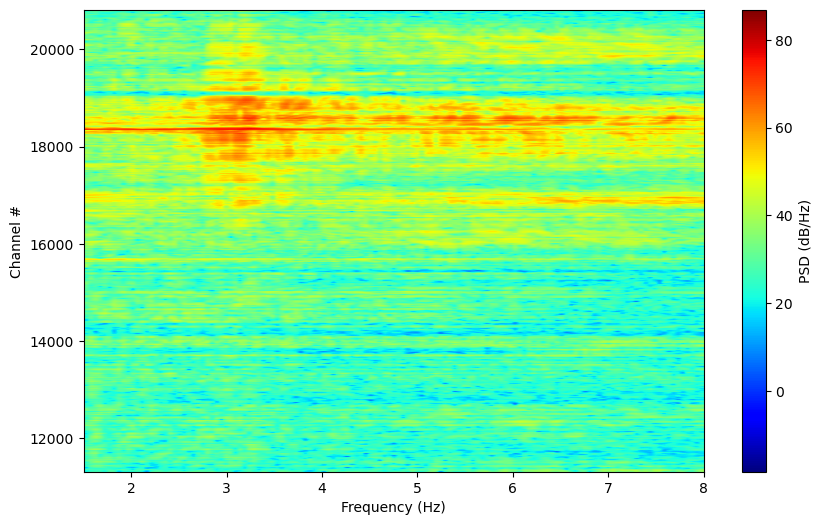

In [3]:
# Load das PSDs
f = np.load('data/das_data/truck_psd.npz')['f']
psd_values_truck = np.load('data/das_data/truck_psd.npz')['psd_values']
cha_save = np.load('data/array_pos/cha_save.npz')['cha_save']
bbox_width = np.load('data/array_pos/cha_save.npz')['bbox_width']
bbox_height = np.load('data/array_pos/cha_save.npz')['bbox_height']

# Plot PSDs for a specific frequency range
plt.figure(figsize=(10, 6))  
freq_range = [1.5, 8]  # Frequency range of interest
freq = np.where((f >= freq_range[0]) & (f <= freq_range[1]))[0]  # Filter frequencies

# Plot PSD values as an image
plt.imshow(10 * np.log10(psd_values_truck[:, freq]), aspect='auto', cmap='jet', origin='lower',
           interpolation='gaussian', extent=[freq_range[0], freq_range[1], min(cha_save), max(cha_save)])
plt.colorbar(label='PSD (dB/Hz)')  # Add color bar
plt.xlabel('Frequency (Hz)')
plt.ylabel('Channel #')
plt.show()


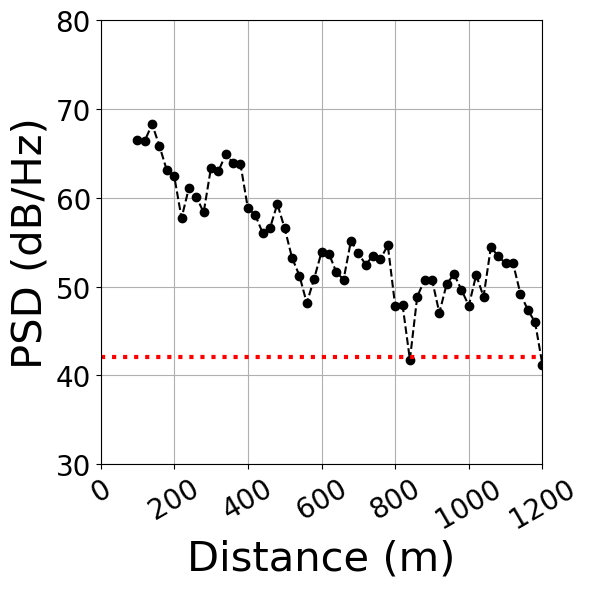

13.841508434661812


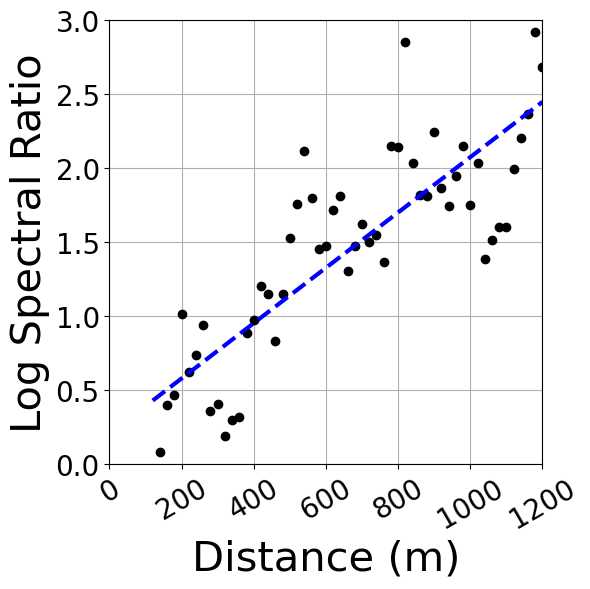

In [4]:
# Calculate Q
freq_ranges_truck = [[3,3.2]]
plt.figure(figsize=(6, 6))  

freq = np.where((f  >= freq_range[0]) & (f  <= freq_range[1]))[0]
cha = np.where(((cha_save  <= 18500) | (cha_save  >= 20000)))[0]
avg = psd_values_truck[cha,:]
avg = np.mean(avg[:,freq])

bins = np.arange(0, 2000, 20) 
ratio = np.zeros((len(bins) - 2, len(freq_ranges_truck)))
start_ref = 5
for i in range(len(freq_ranges_truck)):
    freq = np.where((f  >= freq_ranges_truck[i][0]) & (f  <= freq_ranges_truck[i][1]))[0]
    attenuation_train = np.mean(psd_values_truck[:,freq],1)
    micgeofile = f'../DOA/DASArray_10T.xml'
    mg = acoular.MicGeom(from_file=micgeofile)
    rg = acoular.RectGrid(x_min=-bbox_width/2, x_max=bbox_width/2,
                          y_min=-bbox_height/2, y_max=bbox_height/2,
                          z=0, increment=50)
    env = acoular.Environment()
    distGridToAllMic = env._r(rg.pos(),mg.mpos)
    focus_channel = 18800
    dist = distGridToAllMic[np.argmin(distGridToAllMic[:,np.searchsorted(cha_save, focus_channel)])]

    # Digitize the distance_array to find out which bin each distance belongs to
    indices = np.digitize(dist, bins)

    # For each bin, calculate the average value
    quantized_values = [attenuation_train[indices == i].mean() for i in range(1, len(bins))]     
    for j in range(start_ref, len(bins)-1):
        ratio[j - 1, i] = quantized_values[start_ref-1] / quantized_values[j]       

    plt.plot(bins[start_ref:],10*np.log10(quantized_values[start_ref-1:]),'ko--')
    
# Plot PSD vs Distance
plt.plot([0,2000],10*np.log10([avg,avg]),'r:',linewidth=3)
plt.xlabel('Distance (m)', fontsize=30)
plt.ylabel('PSD (dB/Hz)',fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(rotation=30,fontsize=20)
plt.xlim([0,1200])
plt.ylim([30,80])
plt.grid()
plt.tight_layout()
plt.show()

# Plot Log Spectral Ratio vs Distance
freqs = np.load('data/vs/region3_v.npz')['freqs']
vels = np.load('data/vs/region3_v.npz')['vels']
f_c = interpolate.interp1d(freqs, vels)
fig, ax = plt.subplots(figsize=(6,6))
arange = np.arange(start_ref,60)
x = bins[arange+1]
for i in range(len(freq_ranges_truck)):
    plt.plot(x,np.log(ratio[arange])/2,'ko')
    slope, _, _, _, _ = np.polyfit(x , np.log(ratio[arange,i])/2, 1, full=True)
    print(np.pi*3.1/slope[0]/f_c(3.1))
    fit_line = np.exp(slope[1]) * np.exp(slope[0] * x)
    plt.plot(x, np.log(fit_line), 'b--',linewidth=3)
plt.ylabel('Log Spectral Ratio', fontsize=30)
plt.xlabel('Distance (m)', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(rotation=30,fontsize=20)
plt.xlim([0,1200])
plt.ylim([0,3])
plt.grid()
plt.tight_layout()
plt.show()